## Develop a new class for analyzing comembership properties q(Z)


In [1]:
import imagery_psychophysics.src.variational as very
from imagery_psychophysics.src.stirling_maps import stirling_num_of_2nd_kind as snk
from imagery_psychophysics.src.stirling_maps import stirling_partitions
from skimage.morphology import binary_dilation, binary_erosion
import numpy as np
import pandas as pd
import math
import copy
from matplotlib import pyplot as plt
from os.path import join
from PIL.Image import open as open_image
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable


Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
/tmp/try_flags_02ij8E.c:4:19: fatal error: cudnn.h: No such file or directory
compilation terminated.

Mapped name None to device cuda: GeForce GTX TITAN X (0000:01:00.0)


#### Some data

In [88]:
store = pd.io.pytables.HDFStore('/home/tnaselar/NAS/tnaselar/imagery_probe/noisyTrainedExampleModel.h5', 'r')

In [89]:
resultsDf = store['df']

In [90]:
resultsDf

,targetZOneHot,trainedModel
0,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",<imagery_psychophysics.src.variational.VI obje...


In [91]:
store.close()

In [92]:
trainedModel = resultsDf['trainedModel'][0]


In [93]:

targetZOneHot = resultsDf['targetZOneHot'][0]

In [483]:
class comembership_analyzer(object):
    def __init__(self, trainedModel, relax=True):
        '''
        comembership_analyzer(trainedModel, relax=True)
        
        some methods for analyzing the pairwise comembership properties of pixels under q(Z)
        for a trained VI model
        
        initialization arguments:
            trainedModel ~ a trained VI model
            relax ~ true by default, this will replace all 0's in the qZ with tiny number, to keep analyses from
                    exploding. ideally the prior on Z will be set so that we don't have to do this.
        '''
        #self.trainedModel = trainedModel
        self.D1,self.D2 = (trainedModel.responses.Z.numPixels.D1, trainedModel.responses.Z.numPixels.D2)
        self.D = self.D1*self.D2
        self.K = trainedModel.responses.Z.categoryPrior.numObjects.K
        #explicitly copy qZ of the trained model since we want to cast it and may otherwise fuck with it
        self.qZ = copy.deepcopy(trainedModel.bestQZ.astype('float64'))
        #by default we relax and renormalize to avoid having to deal with degenerate distributions
        if relax:
            self.relax_and_renormalize()
        #finally, pre-calculate the probability under q of any two pixels belonging together...
        self.qZComemProb = self.comembership_indicator(self.qZ.astype('float64'))
        
        ##want to copy ability to see samples: note this takes K x D, not 1 x K x D
        self.view_sample = lambda x,y: trainedModel.responses.Z.view_sample(x[np.newaxis],show=y)
        
        ##and copy ability to produce samples: 
        self.sample = lambda m: trainedModel.responses.Z.sample(M=m,pZ=self.qZ.astype('float32'))
        
    
    def relax_and_renormalize(self, fudge=10e-16):
        '''
        relax_and_renormalize(fudge=10e-16)
        sometimes the model is just too good (or bad) and learns degenerate distributions
        for one or more pixels. this can make analyses really painful. so here we find all pixels
        with degenerate distributions and relax them by adding a small non-zero probability where needed,
        then renormalize
    
        '''
        
#         self.qZ = np.where(self.qZ <= tooSmall, self.qZ+fudge, self.qZ)
        self.qZ = np.clip(self.qZ, fudge, 1)
        self.qZ /= np.sum(self.qZ, axis=0)
        if not np.all(np.abs(np.sum(self.qZ,axis=0)-1.0) < fudge):
            self.relax_and_renormalize(fudge = fudge*10)
        if not np.all(np.abs(np.sum(self.qZ.astype('float32'),axis=0)-1.0) < np.sqrt(fudge)):
            self.relax_and_renormalize(fudge = fudge*10)
        
        print 'relaxation fudge factor: %e' %(fudge)

    def comembership_indicator(self, objectMap):
        '''
        comembership_indicator(objectMap)
        inputs:
            objectMap ~ K x D
        outputs:
            a D x D matrix of comembership indicators
            ie, 0 or 1 for each pair of pixels that don't/do belong to same object
        '''
#         ##only makes sense if given a legit objectMap, so check first
#         assert(np.sum(np.sum(objectMap))==self.D)
        return objectMap.T.dot(objectMap)
    
    def sample_object_maps_with_known_object(self, knownPixels=None, M=1):
        '''
        sample_object_maps_with_known_object(knownPixels=None, M=1)
        produces M samples from q(Z) given that knownPixels all belong to same object
        and no other pixels belong to that object
        
        inputs:
            knownPixels ~ list of pixel indices (into the K x D object maps). or a list of lists.
        
        outputs:
            M x K x D array of samples from q(Z) given that knowPixels all belong to same object
            
        '''
        ##initialize object map sample array
        objectMaps = np.zeros((M,self.K,self.D)).astype('int64')
        
        if knownPixels is None:
            return self.sample(M)
           
        ##get indices for unknown pixels
        unknownPixels = range(self.D)
        [unknownPixels.remove(pix) for pix in knownPixels]
        #get probability that the known pixels belong to object k
        unnorm = np.exp(np.sum(np.log(self.qZ[:,knownPixels]),axis=1))
        prob_of_k = np.exp(np.log(unnorm)-np.log(np.sum(unnorm)))
        #sample an object from that distribution
        selected_objects = np.random.multinomial(1,prob_of_k,size=M).astype('bool')
        ##loop over all samples
        for m,k in zip(range(M),selected_objects):
            #assign known pixels to that row in the object map
            theObject = np.arange(self.K)[k]
            img,row,col = np.meshgrid(m, theObject, knownPixels)
            objectMaps[[img,row,col]] = 1
            ##now deal with the rest of the objects/pixels
            notTheObject = np.arange(self.K)[~k]
            #normalize probabilities for the rest of the pixels
            prob_of_not_k = 1-self.qZ[theObject][:,unknownPixels]
            qZNormalized = (self.qZ[notTheObject][:,unknownPixels])/(prob_of_not_k.reshape((1,len(unknownPixels))))

            #sample labels for those pixels.
            labels = np.array(map(lambda pval: np.random.multinomial(1, pval), qZNormalized.T)).T
            ##assign labels to remaining pixels
            img,row,col = np.meshgrid(m, notTheObject, unknownPixels)
            if labels.size:
                objectMaps[[img,row,col]] = labels[:,np.newaxis,:]
            
        return objectMaps
    
    def log_prob_comembership_indicator(self, objectMap):
        '''
        log_prob_comembership_indicator(objectMap)
        returns the log probability of the comembership indicator matrix
        of the input objectMap
        
        inputs:
            objectMap ~ K x D
        outputs:
            logProb ~ scalar
        '''
        
        
#         small = 10e-16
#         big = 1-small        
        C = self.qZComemProb
        logC = np.log(C)
        logOneMinusC = np.log(1-C)
        cmi = self.comembership_indicator(objectMap).astype('float64')
        logProb = np.sum(np.sum(np.triu(cmi*logC+(1-cmi)*logOneMinusC,1)))
        return logProb
    
    def entropy(self, M=0):
        '''
        entropy(M=0)
        by default, rurns analytical entropy of qZ
        if M > 0, estimates entropy by calculating expected_log_prob_comembership across M samples
        '''
        if M:
            negentropy,_,_=self.expected_log_prob_comembership(M=M)
        else:
            negentropy = self.log_prob_comembership_indicator(self.qZ)
        return -negentropy

    def expected_log_prob_comembership(self,knownPixels = None, M = 100):
        '''
        expected_log_prob_comembership(knownPixels = None, M = 100)
        samples M object maps from q(Z) assuming that all pixels in "knownPixels" belong to the
        same object. computes the expected log prob of comembership across these samples.
        
        note: if no knownPixels, this should approximate -H(q(Z))
        
        inputs:
            knownPixels ~ a list of integers (I think booleans will work too) indices
            M ~ number of samples for computed expectation
        outputs:
            expected log prob ~ scalar, arithmetic mean of log comembership probability across all M samples
            logProbs ~ list of logProbs for each individual sample
            samples ~ list of sampled object maps used to compute expectation
        '''
#         if knownPixels is None:
#             return -self.entropy
#         else:
        s = self.sample_object_maps_with_known_object(knownPixels, M=M)
        logProbs = map(self.log_prob_comembership_indicator, s)
        return np.mean(logProbs), logProbs, s
        
    def optimize_object_scale(self, knownPixels, M=100, selem=None):
        originalObjectMask = np.zeros(self.D)
        originalObjectMask[knownPixels]=1
        originalObjectMask = originalObjectMask.reshape((self.D1,self.D2))
        rescaledObjectMasks = recursively_rescale_object(originalObjectMask,selem=selem) ## a list of eroded/dilated objects, original in the middle
        expected_log_probs = np.zeros(len(rescaledObjectMasks))
        for i,objectMask in enumerate(rescaledObjectMasks):
            pixelIdx = np.where(objectMask.flatten())[0]
            explp,_,_ = self.expected_log_prob_comembership(pixelIdx, M=M)
            expected_log_probs[i] = explp
        return expected_log_probs, rescaledObjectMasks
    
    def optimize_object_location(self, knownPixels, M = 100):
        originalObjectMask = np.zeros(self.D)
        originalObjectMask[knownPixels]=1
        originalObjectMask = originalObjectMask.reshape((self.D1,self.D2))
        translatedObjectMasks = move_object_to(originalObjectMask)
        expected_log_probs = np.zeros((self.D1,self.D2)) ##"it is known"
        for d1 in range(self.D1):
            for d2 in range(self.D2):
                pixelIdx = np.where(translatedObjectMasks[d1,d2,:,:].flatten())[0]
                explp,_,_ = self.expected_log_prob_comembership(pixelIdx, M=M)
                expected_log_probs[d1,d2] = explp
        return expected_log_probs, translatedObjectMasks
    
    def posterior_image_identification(self, candidateObjectMapStack):
        '''
        posterior_image_identification(lureObjectMapStack)
        take a stack of "lure" object maps, compute log prob. of comembership for each,
        return, along with index of highest log. prob. if "real" object map is in the stack,
        this can be used for image identification
        '''
        ##big nasty loop
        N = candidateObjectMapStack.shape[0]
        logProbs = np.zeros(N)
        for i,objectMap in enumerate(candidateObjectMapStack):    
            logProbs[i]=self.log_prob_comembership_indicator(objectMap)
        return logProbs, np.argmax(logProbs)
    
    def kl_divergence(self, pZ, M=100):
        '''
        kl_divergence(pZ)
        returns KL(q | p), the kullback-lieber divergence between q(Z) and comparison_distribution p(Z)
        uses the comemberhsip probability because object identities in q and p will not mean the same thing in general.
        however, this only produces meaningful estimates if q and p have the same support.
        
        inputs:
            pZ ~ a K x D distribution
            Note: we don't do 
        '''
        p = pZ.T.dot(pZ).astype('float64')
        q = self.qZComemProb
        
        crossentropy = np.sum(np.sum(np.triu(-q*np.log(p) - (1-q)*np.log(1-p),1)))
        return crossentropy - self.entropy()
        
        
        
        
            


In [314]:
def recursively_rescale_object(objectMask,selem=None):
    '''
    recursively_rescale_object(objectMask,selem=np.ones((2,2)))
    makes of list of rescaled objects from very tiny to very big
    objectMask is a binary matrix in "canonical" format (i.e., rows x cols image)
    '''
    def recurse(objectMask,thresh_func, warp_func):
        objectMask = warp_func(objectMask,selem)
        if thresh_func(objectMask):
            return [objectMask]+recurse(objectMask, thresh_func, warp_func)
        return []
    #shrink
    warp_func = binary_erosion
    thresh_func = np.sum
    shrunk = recurse(objectMask,thresh_func, warp_func)
    
    #dilate
    warp_func = binary_dilation
    thresh_func = lambda x: np.sum(x) < objectMask.size
    dilated = recurse(objectMask,thresh_func, warp_func)
    
    return list(reversed(shrunk))+[objectMask]+dilated 


In [345]:
from scipy.ndimage.measurements import center_of_mass
from skimage.transform import AffineTransform, warp

In [536]:
def move_object_to(objectMask,distance=None):
    from scipy.ndimage.measurements import center_of_mass
    from skimage.transform import AffineTransform, warp
    '''
    move_object_to(objectMask,distance=None)
    create a copy of the object centered at each pixel in the original mask
    So, if there are D pixels, this will return D object masks with the object translated to each of D positions.
    If distance = n, will only return positions that are  >= n pixels away in either x or y direction.
    Inputs:
        objectMask ~ D1 x D2 binary matrix (a proper image of the object mask)
        distance ~ integer, default is none. restrict translation to this many pixels
    
    '''
    D1,D2 = objectMask.shape
#     objectCenterOfMass = center_of_mass(objectMask)
    fieldCenterOfMass = np.array(center_of_mass(np.ones((D1,D2))))
    masks = np.zeros((D1,D2,D1,D2))
    for d1 in range(D1):
        for d2 in range(D2):
            translation = fieldCenterOfMass - np.array([d1,d2])
#             translation = objectCenterOfMass - np.array([d1,d2])
            xform = AffineTransform(translation = translation)
            masks[d1,d2,:,:] = warp(objectMask,xform.params,order=0, preserve_range=True,clip=True)
    return masks
    

In [537]:
comem = comembership_analyzer(trainedModel)

relaxation fudge factor: 1.000000e-13
relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15


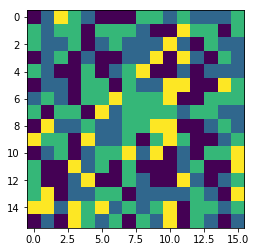

In [491]:
Z = comem.sample_object_maps_with_known_object(M=100)
_=comem.view_sample(Z[99],True) 

In [492]:
anal= comem.entropy()
samplenums = np.logspace(0,4,num=10,dtype='int32')
est = np.zeros(10)
for i,m in enumerate(samplenums):
    est[i] = comem.entropy(M=m)

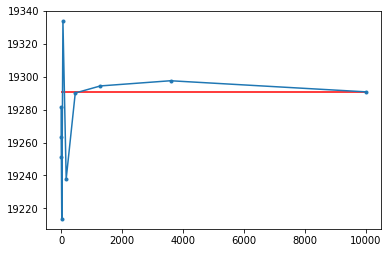

In [493]:
plt.plot(np.logspace(0,4,num=10,dtype='int32'), est, '.-')
plt.hlines(anal,np.min(samplenums),np.max(samplenums), colors='r')

In [494]:
randoPixels = np.random.permutation(comem.D)[0:10]
# s = comem.sample_object_maps_with_known_object(randoPixels,M=10)
expectLogProb, logProbs, s = comem.expected_log_prob_comembership(randoPixels)
len(logProbs)

100

Text(0.5,1,u'logProb: -19809.899340')

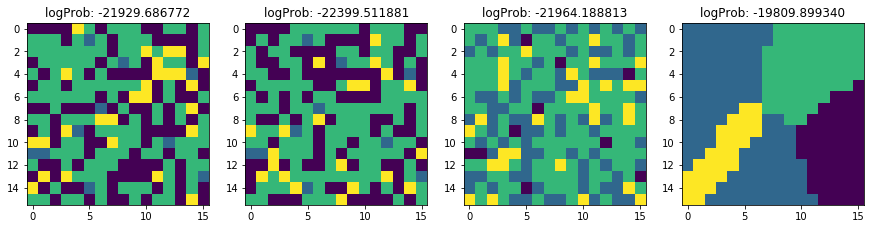

In [495]:
fig = plt.figure(figsize=(15,45))
for ii,k in enumerate(np.random.permutation(np.arange(1,101)[:3])):
    plt.subplot(1,4,ii+1)
    _= trainedModel.responses.Z.view_sample(s[(k-1):k,:,:])
    plt.title('logProb: %f' %(logProbs[k-1]))

plt.subplot(1,4,4)
_= trainedModel.responses.Z.view_sample(targetZOneHot[:1,:,:])
targLogProb = comem.log_prob_comembership_indicator(targetZOneHot[0])
plt.title('logProb: %f' %(targLogProb))



expected log prob: -21620.089076


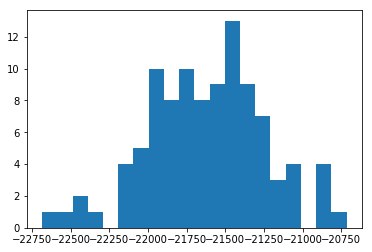

In [496]:
_=plt.hist(logProbs, bins=20)
print 'expected log prob: %f' %(expectLogProb)

In [497]:
knownPixels = np.where(targetZOneHot[0][2]==1)[0]
expectLogProbReal, logProbsReal, sReal = comem.expected_log_prob_comembership(knownPixels,M=100)

Text(0.5,1,u'logProb: -19809.899340')

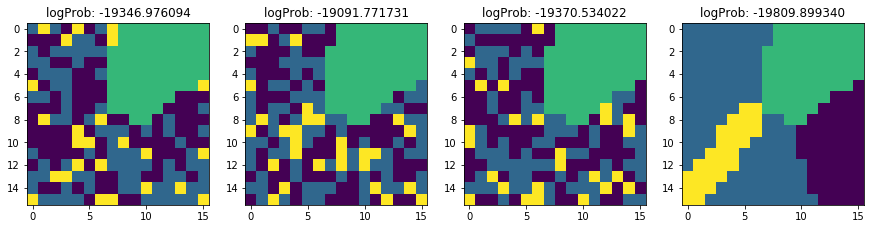

In [498]:
fig = plt.figure(figsize=(15,45))
for ii,k in enumerate(np.random.permutation(np.arange(1,101)[:3])):
    plt.subplot(1,4,ii+1)
    _= trainedModel.responses.Z.view_sample(sReal[(k-1):k,:,:])
    plt.title('logProb: %f' %(logProbsReal[k-1]))

plt.subplot(1,4,4)
_= trainedModel.responses.Z.view_sample(targetZOneHot[:1,:,:])
targLogProb = comem.log_prob_comembership_indicator(targetZOneHot[0])
plt.title('logProb: %f' %(targLogProb))

expected log prob: -19457.155299


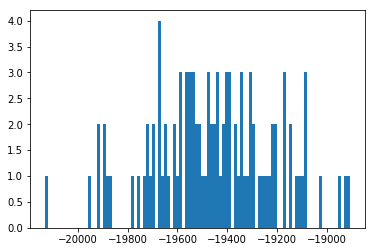

In [499]:
_=plt.hist(logProbsReal, bins=100)
print 'expected log prob: %f' %(expectLogProbReal)

In [500]:
knownObjectIdx = 3
knownPixels = np.where(targetZOneHot[0][knownObjectIdx]==1)[0]
knownMask = targetZOneHot[0][knownObjectIdx, :].reshape((comem.D1, comem.D2))
knownLogProb, _, _ = comem.expected_log_prob_comembership(knownPixels)
expect_log_probs, objectMasks = comem.optimize_object_scale(knownPixels)

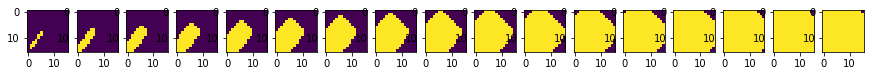

In [501]:
fig = plt.figure(figsize=(15,45))
for ii,k in enumerate(range(len(objectMasks))):
    plt.subplot(1,len(objectMasks),ii+1)
    plt.imshow(objectMasks[ii].astype('bool'))

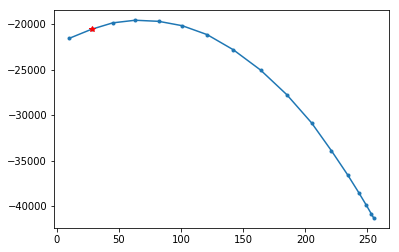

In [502]:
plt.plot(map(np.sum, objectMasks), expect_log_probs, '.-')
plt.plot(len(knownPixels), knownLogProb, 'r*')

In [552]:
knownObjectIdx = 1
knownPixels = np.where(targetZOneHot[0][knownObjectIdx]==1)[0]
knownMask = targetZOneHot[0][knownObjectIdx, :].reshape((comem.D1, comem.D2))
knownLogProb, _, _ = comem.expected_log_prob_comembership(knownPixels)
expect_log_probs, objectMasks = comem.optimize_object_location(knownPixels)

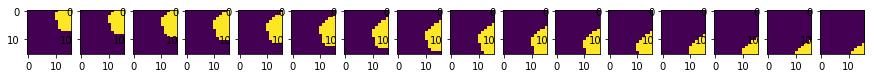

In [550]:
fig = plt.figure(figsize=(15,45))
for d2 in range(comem.D2):
    plt.subplot(1,int(comem.D2),d2+1)
    plt.imshow(objectMasks[8,d2].astype('bool'))

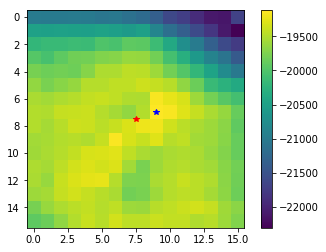

In [553]:
plt.imshow(expect_log_probs)
plt.colorbar()
plt.plot(7.5, 7.5, 'r*')
maxi,maxj = np.unravel_index(np.argmax(expect_log_probs), (comem.D1,comem.D2))
plt.plot(maxj,maxi, 'b*')

In [544]:
np.argmin(expect_log_probs,axis=0)

array([2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0])

0.882


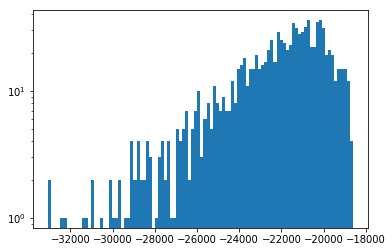

In [321]:
targIdx = 100
lureZ = very.make_object_map_stack(comem.K, 2, 3, (comem.D1,comem.D2), 1000)
lureZ[targIdx] = targetZOneHot[0]
logProbs, bestZ = comem.posterior_image_identification(lureZ)
_=plt.hist(logProbs, bins=100, log=True)
rank =  np.where(np.argsort(logProbs)==targIdx)[0][0]
print rank/1000.

In [322]:
trainedModel.bestNoiseParam

array([0.79532653, 0.12305024], dtype=float32)

In [323]:
comem.kl_divergence(comem.qZ)

0.0

In [ ]:
##but need to sum over all numbers of objects from 1 to K, because these are all on the support of q
num = snk(9,3)
sp = stirling_partitions(range(9),3)

maps = np.zeros((int(num), 3,9))
for ii,obj in enumerate(sp):
    for k in range(3):
        maps[ii][k][obj.pop()]=1
